## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

## Часть 1

Требования

1. Используйте фреймворк [Pytorch](https://pytorch.org/)

2. Не используйте предобученные модели.

3. Можете загрузить готовую модель или использовать собственную архитектуру.

4. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

5. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

6. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST, CIFAR10
from torchvision.transforms import ToTensor
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import wandb
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

- Загрузим датасет, посмотрим на его параметры, определим аугментацию

In [2]:
# Аугментация
transforms = A.Compose([
    # Горизонтальное отражение
    A.HorizontalFlip(p=0.5),

    # Вращение от -40 до +40 градусов
    A.Rotate(limit=40, p=0.5),

    # Случайное обрезание и изменение размера изображения
    A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),

    # Случайное изменение яркости и контраста
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    # Случайное зануление прямоугольных областей
    A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.5),
    A.ToFloat(max_value=255),
    ToTensorV2()
])

In [3]:
# Класс для корректой работы с библиотекой albumentations
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)
        augmented = self.transform(image=img)
        return augmented['image']

In [4]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=AlbumentationsTransform(transforms))
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=AlbumentationsTransform(A.Compose([A.ToFloat(max_value=255),ToTensorV2()])))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"Размер train_dataset: {len(train_dataset)}\n",
     f"Размер test_dataset: {len(test_dataset)}", sep='')

Размер train_dataset: 50000
Размер test_dataset: 10000


In [6]:
len(train_dataset)

50000

In [7]:
train_class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset:
    class_name = train_dataset.classes[label]
    train_class_counts[class_name] += 1
print(pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count']))

        Class  Count
0    airplane   5000
1  automobile   5000
2        bird   5000
3         cat   5000
4        deer   5000
5         dog   5000
6        frog   5000
7       horse   5000
8        ship   5000
9       truck   5000


Данные идеально сбалансированы по классам

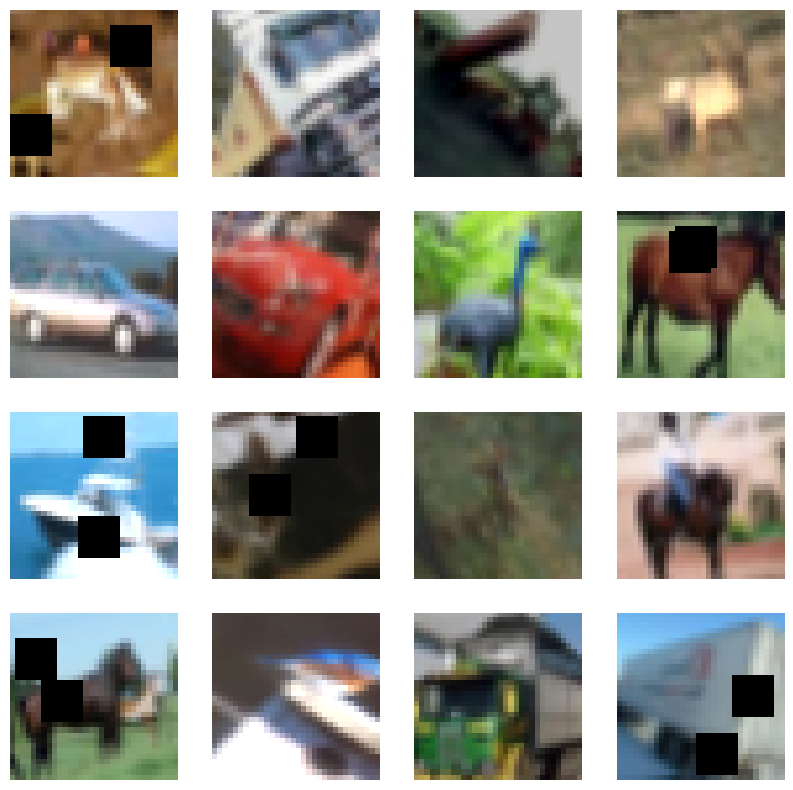

In [8]:
images = [train_dataset[i][0] for i in range(16)]
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.show()

- Определим архитектуру нейронной сети

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten()
        self.lin1 = nn.Sequential(
            nn.Linear(in_features=128*5*5, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.lin2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.lin1(x)
        logits = self.lin2(x)
        return logits

- Определим класс с параметрами обучения

In [10]:
@dataclass
class Config:
    seed: int = 42
    
    # Данные
    batch_size: int = 256
    img_size: int = 32
    ratio_train_val_test: tuple = (0.8, 0.1, 0.1)
    do_shuffle_train: bool = True
    
    # Обучение
    n_epochs: int = 30
    eval_every: int = 10
    lr: float = 1e-3

In [11]:
config = Config()

- Зафиксируем случайности для воспроизводимости результата

In [12]:
import os
import numpy as np
import random

# Чтобы pytorch использовал внутри cuda детерминированные алгоритмы
def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)

def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

enable_determinism()
fix_seeds(config.seed)

- Создадим DataLoader-s

In [13]:
generator = torch.Generator()
generator.manual_seed(config.seed)

def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=config.do_shuffle_train,
    generator=generator,
    drop_last=True,
    pin_memory=True,
    # Это для воспроизводимости https://pytorch.org/docs/stable/notes/randomness.html
    worker_init_fn=seed_worker,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True
)

- Функция для подсчета метрики accuracy

In [14]:
def calc_accuracy(y_preds: torch.tensor, y_true: torch.tensor):
    predicted_classes = torch.argmax(y_preds, dim=1)
    correct_predictions = (predicted_classes == y_true).float()
    accuracy = correct_predictions.mean()
    return accuracy.item()

- Определим функции сохранения и загрузки модели и оптимизатора

In [15]:
def save_model_and_optimizer(model, optimizer, model_path='model.pt', optimizer_path='optimizer.pt'):
    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)

In [16]:
def load_model_and_optimizer(model, optimizer, model_path='model.pt', optimizer_path='optimizer.pt'):
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    return model, optimizer

- Функция для обучения

In [17]:
def train_loop(
    config: Config,
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
    params_subset: list | None = None,
    optimizer_state: dict | None = None
):
    if params_subset is None:
        params_subset = model.parameters()
    optimizer = Adam(params_subset, lr=config.lr)
    if optimizer_state is not None:
        optimizer.load_state_dict(optimizer_state)
    model.train()
    for epoch in range(config.n_epochs):
        print(f"Epoch #{epoch + 1}/#{config.n_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            optimizer.zero_grad()
            pred_labels = model(img_batch)
            loss_train = F.cross_entropy(pred_labels, true_labels)
            loss_train.backward()
            optimizer.step()
            
            metrics = {'loss_train': loss_train.detach().cpu().item(),}
            if (i + 1) % config.eval_every == 0:
                model.eval()
                for i, (img_batch_val, true_labels_val) in enumerate(test_loader):
                    img_batch_val, true_labels_val = img_batch_val.to(device), true_labels_val.to(device)
                    with torch.no_grad():
                        loss_val = F.cross_entropy(model(img_batch_val), true_labels_val)
                        outputs = model(img_batch_val)
                        accuracy = calc_accuracy(outputs, true_labels_val)
                        metrics.update({'loss_val': loss_val, 'accuracy_val': accuracy})
                        wandb.log(metrics, step=step)
                model.train()
            wandb.log(metrics, step=step)
        save_model_and_optimizer(model, optimizer, model_path='model.pt', optimizer_path='optimizer.pt')
    return optimizer

- Определим device

In [18]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("using device:", device)

using device: cuda


- Запустим обучение

In [18]:
config = Config(n_epochs=60, lr=1e-3)
model = CNNModel()
model.to(device)
wandb.init(project="cifar10-classification", name="CNNModel_without_Dropout", config=config.__dict__)
res = train_loop(config, model, train_loader, test_loader, device=device)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nekhoroshkin-mihail (misha_n). Use `wandb login --relogin` to force relogin


Epoch #1/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:18<00:00,  2.48it/s]


Epoch #2/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #3/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:19<00:00,  2.47it/s]


Epoch #4/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:22<00:00,  2.36it/s]


Epoch #5/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:19<00:00,  2.44it/s]


Epoch #6/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:18<00:00,  2.47it/s]


Epoch #7/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:25<00:00,  2.29it/s]


Epoch #8/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:21<00:00,  2.39it/s]


Epoch #9/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:19<00:00,  2.46it/s]


Epoch #10/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:22<00:00,  2.37it/s]


Epoch #11/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:21<00:00,  2.40it/s]


Epoch #12/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.50it/s]


Epoch #13/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #14/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #15/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:19<00:00,  2.46it/s]


Epoch #16/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #17/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #18/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #19/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.53it/s]


Epoch #20/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #21/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #22/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.50it/s]


Epoch #23/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.53it/s]


Epoch #24/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #25/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #26/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.50it/s]


Epoch #27/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #28/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #29/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #30/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.51it/s]


Epoch #31/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:17<00:00,  2.52it/s]


Epoch #32/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:18<00:00,  2.49it/s]


Epoch #33/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:18<00:00,  2.49it/s]


Epoch #34/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:21<00:00,  2.40it/s]


Epoch #35/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:22<00:00,  2.38it/s]


Epoch #36/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:19<00:00,  2.45it/s]


Epoch #37/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:20<00:00,  2.42it/s]


Epoch #38/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:20<00:00,  2.43it/s]


Epoch #39/#60


 67%|█████████████████████████████████████████████████████▎                          | 130/195 [00:53<00:26,  2.41it/s]


KeyboardInterrupt: 

- Попробуем улучшить модель

In [60]:
class CNNModel_V2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        # Вместо обычного слоя - 3 слоя с разными размерами ядер, которые потом конкатенируются по оси каналов
        self.conv3_1x1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv3_3x3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.conv3_5x5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        # Вместо обычного слоя - 3 слоя с разными размерами ядер, которые потом конкатенируются по оси каналов
        self.conv4_3x3 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv4_5x5 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3)
        )
        self.flatten = nn.Flatten()
        self.lin1 = nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.lin2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x1 = self.conv3_1x1(x)
        x2 = self.conv3_3x3(x)
        x3 = self.conv3_5x5(x)
        
        x = torch.cat((x1, x2, x3), dim=1)

        x4_3x3 = self.conv4_3x3(x)
        x4_5x5 = self.conv4_5x5(x)
        
        x = torch.cat((x4_3x3, x4_5x5), dim=1)
        
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.lin1(x)
        logits = self.lin2(x)
        return logits

In [69]:
config = Config(n_epochs=60, lr=1e-3)
model = CNNModel_V2()
model.to(device)
wandb.init(project="cifar10-classification", name="CNNModel_V2", config=config.__dict__)
res = train_loop(config, model, train_loader, test_loader, device=device)
wandb.finish()

loss_train,▁█
loss_train,2.88206


Epoch #1/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [13:23<00:00,  4.12s/it]


Epoch #2/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [13:21<00:00,  4.11s/it]


Epoch #3/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [13:21<00:00,  4.11s/it]


Epoch #4/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:07<00:00,  4.35s/it]


Epoch #5/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.46s/it]


Epoch #6/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #7/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #8/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #9/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #10/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.47s/it]


Epoch #11/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #12/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #13/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #14/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #15/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #16/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #17/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:27<00:00,  4.45s/it]


Epoch #18/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.46s/it]


Epoch #19/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:27<00:00,  4.45s/it]


Epoch #20/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #21/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #22/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #23/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #24/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:27<00:00,  4.45s/it]


Epoch #25/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #26/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #27/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #28/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #29/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.46s/it]


Epoch #30/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #31/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #32/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:08<00:00,  4.35s/it]


Epoch #33/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [13:22<00:00,  4.11s/it]


Epoch #34/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [13:24<00:00,  4.13s/it]


Epoch #35/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #36/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:29<00:00,  4.46s/it]


Epoch #37/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.46s/it]


Epoch #38/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:31<00:00,  4.47s/it]


Epoch #39/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:32<00:00,  4.48s/it]


Epoch #40/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:30<00:00,  4.47s/it]


Epoch #41/#60


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [14:28<00:00,  4.45s/it]


Epoch #42/#60


 66%|████████████████████████████████████████████████████▉                           | 129/195 [08:56<04:34,  4.16s/it]


KeyboardInterrupt: 

- Сделаем итоговое предсказание

In [72]:
model.eval()

CNNModel_V2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3_1x1): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3_3x3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3_5x5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(

In [74]:
total_accuracy = 0
num_batches = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        batch_accuracy = calc_accuracy(outputs, labels)
        total_accuracy += batch_accuracy
        num_batches += 1

average_accuracy = total_accuracy / num_batches
print(f'Accuracy: {average_accuracy}')

Accuracy: 0.8592748397435898


Получившаяся улучшенная модель сильно тяжелее, чем предыдущая, но результат тоже двольно сильно улучшился. Далее будем пробовать использовать готовую архитектуру - ResNet18

## Часть 2


1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


- Импортируем resnet18

In [19]:
from torchvision.models import resnet18
import cv2

- Поменяем предобработку данных с учетом [комментариев](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) по resnet18

In [20]:
# Аугментация
transforms_augmentation = A.Compose([
    
     # Изменение размера до 256x256 с использованием билинейной интерполяции
    A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR),

    # Центральное обрезание до 224x224
    A.CenterCrop(height=224, width=224),

    # Горизонтальное отражение
    A.HorizontalFlip(p=0.5),

    # Вращение от -40 до +40 градусов
    A.Rotate(limit=40, p=0.5),

    # Случайное обрезание и изменение размера изображения
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),

    # Случайное зануление прямоугольных областей
    A.CoarseDropout(max_holes=2, max_height=50, max_width=50, p=0.5),

    # Нормализация
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    # Преобразование в тензор
    ToTensorV2()
])

# Преобразования для теста
transforms = A.Compose([
    
     # Изменение размера до 256x256 с использованием билинейной интерполяции
    A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR),

    # Центральное обрезание до 224x224
    A.CenterCrop(height=224, width=224),

    # Нормализация
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    # Преобразование в тензор
    ToTensorV2()
])

In [21]:
train_dataset_resnet = CIFAR10(root='./data', train=True, download=True, transform=AlbumentationsTransform(transforms_augmentation))
test_dataset_resnet = CIFAR10(root='./data', train=False, download=True, transform=AlbumentationsTransform(transforms))

Files already downloaded and verified
Files already downloaded and verified


In [22]:
generator = torch.Generator()
generator.manual_seed(config.seed)

def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=config.batch_size,
    shuffle=config.do_shuffle_train,
    generator=generator,
    drop_last=True,
    pin_memory=True,
    # Это для воспроизводимости https://pytorch.org/docs/stable/notes/randomness.html
    worker_init_fn=seed_worker,
)

test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

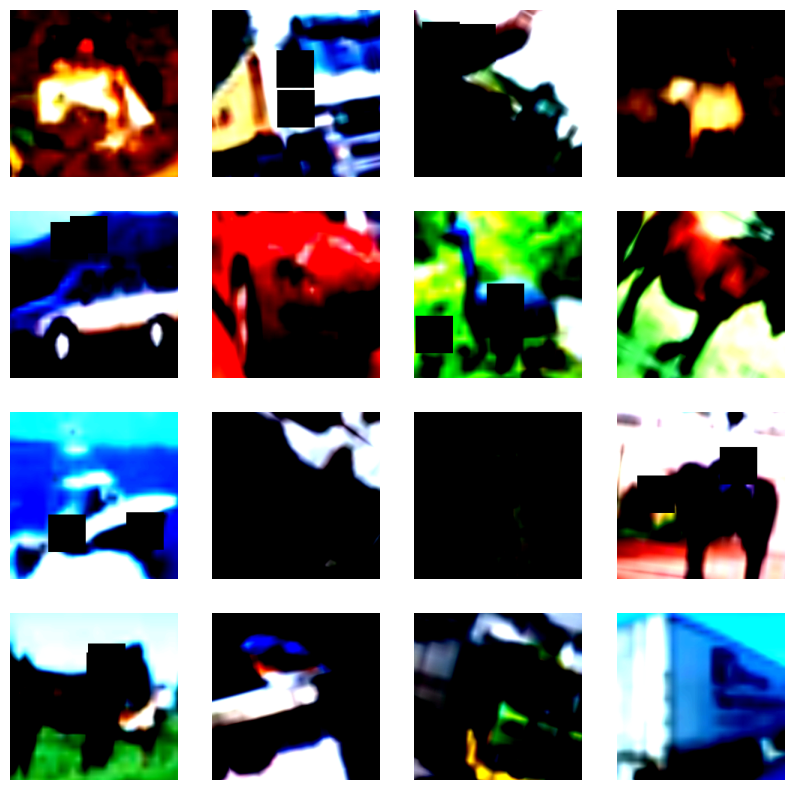

In [23]:
images = [train_dataset_resnet[i][0] for i in range(16)]
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.show()

- Посмотрим на последние слои resnet34

In [24]:
resnet = resnet18(weights='IMAGENET1K_V1')

In [25]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

- Уберем последний линейный слой и добавим свои для обучения

In [56]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.resnet = resnet18(weights='IMAGENET1K_V1')
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Дообучаем последний Sequential блок, состоящий из двух BasicBlock
        for param in list(self.resnet[-1].parameters()):
            param.requires_grad = True

        # Добавим два своих сверточных слоя на выходе resnet
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.adapt = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.out = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.adapt(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [27]:
resnet = CustomResNet18()

In [28]:
resnet

CustomResNet18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

- Посмотрим на параметры, которые необходимо обучать

In [29]:
list(CustomResNet18().named_parameters())

[('resnet.0.weight',
  Parameter containing:
  tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
              1.7083e-02, -1.2694e-02],
            [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
             -1.2907e-01,  3.7424e-03],
            [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
              2.5632e-01,  6.3573e-02],
            ...,
            [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
             -4.2058e-01, -2.5781e-01],
            [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
              3.9359e-01,  1.6606e-01],
            [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
             -8.2230e-02, -5.7828e-03]],
  
           [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
              6.6221e-04, -2.5743e-02],
            [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
             -1.6051e-01, -1.2826e-03],
            [-8.3730e-04,  9.8420e-02,  4.0210

In [30]:
fc_params = list(resnet.resnet[-1].parameters()) + list(resnet.out.parameters()) + list(resnet.conv1.parameters()) + list(resnet.conv2.parameters())

In [31]:
config = Config(batch_size=128, eval_every=195, n_epochs=40)

In [32]:
resnet.to(device)
wandb.init(project="cifar10-classification", name="resnet18_2conv_3linear_lastFinetune_dropout", config=config.__dict__)
res = train_loop(config, resnet, train_loader_resnet, test_loader_resnet, device=device, params_subset=fc_params)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nekhoroshkin-mihail (misha_n). Use `wandb login --relogin` to force relogin


Epoch #1/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:04<00:00,  1.26s/it]


Epoch #2/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:53<00:00,  1.20s/it]


Epoch #3/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:52<00:00,  1.19s/it]


Epoch #4/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:51<00:00,  1.19s/it]


Epoch #5/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:51<00:00,  1.19s/it]


Epoch #6/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:39<00:00,  1.12s/it]


Epoch #7/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:38<00:00,  1.12s/it]


Epoch #8/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:36<00:00,  1.11s/it]


Epoch #9/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:35<00:00,  1.10s/it]


Epoch #10/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:36<00:00,  1.11s/it]


Epoch #11/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:36<00:00,  1.11s/it]


Epoch #12/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:36<00:00,  1.11s/it]


Epoch #13/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:35<00:00,  1.10s/it]


Epoch #14/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:34<00:00,  1.10s/it]


Epoch #15/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #16/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #17/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:33<00:00,  1.10s/it]


Epoch #18/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:34<00:00,  1.10s/it]


Epoch #19/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:33<00:00,  1.09s/it]


Epoch #20/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #21/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #22/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #23/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:34<00:00,  1.10s/it]


Epoch #24/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:31<00:00,  1.08s/it]


Epoch #25/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #26/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:33<00:00,  1.09s/it]


Epoch #27/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:33<00:00,  1.09s/it]


Epoch #28/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:32<00:00,  1.09s/it]


Epoch #29/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:33<00:00,  1.10s/it]


Epoch #30/#40


 25%|███████████████████▉                                                             | 48/195 [00:45<02:19,  1.06it/s]

KeyboardInterrupt



- Результат удовлетворительный. Попробуем улучшить его.

- Попробуем убрать два "своих" сверточных слоя на выходе и вместо них дообучать два последних Sequetial блока resnet, упростим выходную последовательность линейных слоев

In [26]:
class CustomResNet18_V2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.resnet = resnet18(weights='IMAGENET1K_V1')
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for param in list(self.resnet[-1].parameters()):
            param.requires_grad = True
        for param in list(self.resnet[-2].parameters()):
            param.requires_grad = True

        self.adapt = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.out = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.adapt(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [33]:
resnet1 = CustomResNet18_V2()

In [34]:
fc_params1 = list(resnet1.resnet[-2].parameters()) + list(resnet1.resnet[-1].parameters()) + list(resnet1.out.parameters())

In [35]:
config = Config(batch_size=128, eval_every=195, n_epochs=25, lr=1e-4)

In [29]:
resnet1.to(device)
wandb.init(project="cifar10-classification", name="resnet18_1_2linear_last2Finetune_dropout", config=config.__dict__)
res = train_loop(config, resnet1, train_loader_resnet, test_loader_resnet, device=device, params_subset=fc_params1)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nekhoroshkin-mihail (misha_n). Use `wandb login --relogin` to force relogin


Epoch #1/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:52<00:00,  1.19s/it]


Epoch #2/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #3/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #4/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #5/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #6/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.17s/it]


Epoch #7/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #8/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #9/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:46<00:00,  1.16s/it]


Epoch #10/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:22<00:00,  1.35s/it]


Epoch #11/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:24<00:00,  1.36s/it]


Epoch #12/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:24<00:00,  1.36s/it]


Epoch #13/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:23<00:00,  1.35s/it]


Epoch #14/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:22<00:00,  1.35s/it]


Epoch #15/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:24<00:00,  1.36s/it]


Epoch #16/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:24<00:00,  1.35s/it]


Epoch #17/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:20<00:00,  1.34s/it]


Epoch #18/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:21<00:00,  1.34s/it]


Epoch #19/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:19<00:00,  1.33s/it]


Epoch #20/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:21<00:00,  1.34s/it]


Epoch #21/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:20<00:00,  1.34s/it]


Epoch #22/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:22<00:00,  1.34s/it]


Epoch #23/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:18<00:00,  1.33s/it]


Epoch #24/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:18<00:00,  1.33s/it]


Epoch #25/#25


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [04:14<00:00,  1.31s/it]


accuracy_val,▁▅▇▇█▇█▇▇█▆▇█▇▇█▆▆▇███▇▇▇
loss_train,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▅▄▃▂▂▂▁▁▁▂▂▁▁▁▁▂▂▁▁▁▂▁▂▁
accuracy_val,0.94141
loss_train,0.07552
loss_val,0.15616


- Результат стал лучше. Попробуем дообучить модель, которая обучалась выше.

In [32]:
model = CustomResNet18_V2()

In [33]:
params_to_learn = list(model.resnet[-2].parameters()) + list(model.resnet[-1].parameters()) + list(model.out.parameters())

In [34]:
optimizer = Adam(params_to_learn, lr=config.lr)

In [35]:
config = Config(batch_size=128, eval_every=195, n_epochs=40)

In [36]:
model, optimizer = load_model_and_optimizer(model, optimizer)

In [37]:
model.to(device)
wandb.init(project="cifar10-classification", name="resnet18_1_2linear_last2Finetune_dropout", config=config.__dict__)
res = train_loop(config, model, train_loader_resnet, test_loader_resnet, device=device, params_subset=params_to_learn, optimizer_state=optimizer.state_dict())
wandb.finish()

accuracy_val,▅▆▇▅▇▄▃▅▇▅▆▅▇▄▆▅▃▅▄▃▄▆▅▆▅▅▃▄▁▅▇█▅▄▆▅▆▅
loss_train,▅▇▃▁▅▄▂▄█▂▃▄▃▆▅▃▄▄▁▂▄▄▃▃▄▇▃▄▅▃▁▄█▃▆▂▂▂▄▃
loss_val,▂▂▂▂▁▃▃▁▃▃▁▃▂▃▁▂▇█▅▅▄▂▄▃▄▅▃▃▅▄▃▂▃▄▃▅▃▂
accuracy_val,0.94141
loss_train,0.08451
loss_val,0.14248


Epoch #1/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #2/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #3/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #4/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #5/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:50<00:00,  1.18s/it]


Epoch #6/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #7/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:53<00:00,  1.20s/it]


Epoch #8/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


Epoch #9/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:47<00:00,  1.16s/it]


Epoch #10/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:46<00:00,  1.16s/it]


Epoch #11/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:46<00:00,  1.16s/it]


Epoch #12/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:45<00:00,  1.15s/it]


Epoch #13/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:48<00:00,  1.17s/it]


Epoch #14/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:46<00:00,  1.16s/it]


Epoch #15/#40


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:45<00:00,  1.16s/it]


Epoch #16/#40


 39%|███████████████████████████████▉                                                 | 77/195 [01:16<01:56,  1.01it/s]

KeyboardInterrupt



- Произведем оценку классификации лучшей сохраненной модели

In [54]:
model = CustomResNet18_V2()
model.load_state_dict(torch.load('model.pt'))
model.to(device)
model.eval()

CustomResNet18_V2(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [55]:
total_accuracy = 0
num_batches = 0
with torch.no_grad():
    for images, labels in test_loader_resnet:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        batch_accuracy = calc_accuracy(outputs, labels)
        total_accuracy += batch_accuracy
        num_batches += 1

average_accuracy = total_accuracy / num_batches
print(f'Accuracy: {average_accuracy}')

Accuracy: 0.9545272435897436


## Summary

- Лучший полученный результат дала ResNet18, accuracy = 0.9545. Дообучались последних два Sequential блока ResNet18 (каждый из которых содержит по 2 BasicBlock) и два выходных линейных слоя.

- Лучший результат, полученный при помощи несильно сложной вручную собранной сверточной сети - accuracy = 0.8592. Архитектура примерно следующая:
$$Conv\rightarrow Conv\rightarrow\text{3xConv (1x1, 3x3, 5x5)}\rightarrow\text{2xConv (3x3, 5x5)}\rightarrow MaxPool\rightarrow Conv\rightarrow\text{2xLinear}$$